In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from time import time
import math

In [2]:
df = pd.read_csv('Final Data.csv');
y = df['Power Outage'];
df = df.drop(['Power Outage'], axis=1);
x = df[['5 second wind speed squared','Fog/Ice', 'Thunder']];
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 23);
x_train.head();

In [3]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(x_train);

In [5]:
def euclidean(point1, point2):
    """
    Finds the euclidean distance between two points (tuples of k dimensions each)
    """
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return math.sqrt(distance)


def closestPoint(allNeighbors, point):
    """
    Brute force way to find the closest point
    """
    minDistance = None
    minPoint = None
    for current in allNeighbors:
        currentDistance = euclidean(point, current)
        if minDistance is None or currentDistance < minDistance:
            minDistance = currentDistance
            minPoint = current
    return minPoint


def build_kdtree(points, depth=0):
    """
    Builds a kdtree
    """
    n = len(points)
    # if no points, can't build a kdtree
    if n <=0:
        return None

    axis = depth % k
    # sort the points based on the axis
    sorted_points = sorted(points, key=lambda point: point[axis])
    # the middle index is the splitting point
    mid = n//2
    # return the point, left subtree and right subtree
    return {
        'point': sorted_points[mid],
        'left': build_kdtree(sorted_points[:mid], depth + 1),
        'right': build_kdtree(sorted_points[mid + 1:], depth + 1)
    }


def kdTreeClosest(root, point, depth=0, nearest=None):
    """
    Finds the nearest neighbor in the kdtree
    """
    if root is None:
        return nearest

    axis = depth % k
    # did we find a better result so far?
    next_best = None
    # the next branch to recurse on
    next_branch = None
    # distance between the searching point and the best result (nearest)
    if nearest is None or euclidean(point, nearest) > euclidean(point, root['point']):
        next_best = root['point']
    else:
        next_best = nearest
    # find which tree to recurse on
    # if item on left, recurse on left
    if point[axis] < root['point'][axis]:
        next_branch = root['left']
    else:
        # recurse right
        next_branch = root['right']

    return kdTreeClosest(next_branch, point, depth+1, next_best)

In [8]:
# swarnim kd trees
trainTuples = [tuple(z) for z in x_train.values]
k = len(trainTuples[0])
trainOut = y_train.values
kdTree = build_kdtree(trainTuples)

In [9]:
testTuples = [tuple(z) for z in x_test.values]
testOut = y_test.values

In [10]:
trainTuples.index((0.0038456028917407867, 0.3695652173913045, 6.245004513516506e-17))

4

In [11]:
pred = []
for key, val in enumerate(testTuples):
    kdClosest = kdTreeClosest(kdTree, val)
    kdIndex = trainTuples.index(kdClosest)
    kdOut = trainOut[kdIndex]
    realOut = testOut[key]
    pred.append(kdOut)

Accuracy:  0.796875


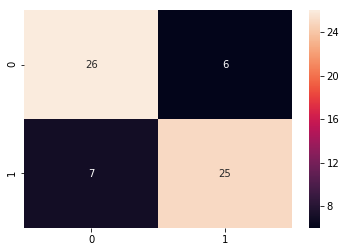

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test.values, pred);
cm = pd.DataFrame(confusion_matrix(y_test, pred));
print("Accuracy: ", accuracy)
sns.heatmap(cm, annot=True);
plt.show();